<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking
import tensorflow.keras.backend as K

In [5]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid'):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#### load some SDSS data


In [6]:
from sdss_pae.sdss_dataset import SDSS

In [7]:
ds, info = tfds.load('SDSS', data_dir='/global/cscratch1/sd/vboehm/Datasets/',with_info=True, split='train')

In [8]:
info

tfds.core.DatasetInfo(
    name='sdss',
    version=1.0.0,
    description='selected features from spAll and spZbest files 
'flux': measured spectrum in  
'inv_var': inverse variance
'and_mask': and mask (set to 1 for all non-zero entries)
'coeffs': c0, c1, npix. calculate wavelengths with `10.**(c0 + c1 * np.arange(npix))`
'label': type of object, 'STAR'==0, 'QSO'==1, 'GALAXY'==2
'redshift': object redshift estimate',
    homepage='https://www.sdss.org/science/data-release-publications/',
    features=FeaturesDict({
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'filename': Text(shape=(), dtype=tf.string),
        'flux': Tensor(shape=(None, 1), dtype=tf.float32),
        'inv_var': Tensor(shape=(None, 1), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        'redshift': tf.float32,
    }),
    total_num_examples=100000,
    splits={
        'train': 100000,
    }

In [9]:
# use only galxies for now
select_by = 2
# de-redhsift or not?
de_redshift = False

In [10]:

def filter_fn(x):
    if select_by is not None:
        return tf.math.equal(x['label'], 2)
    else: return 1

ds = ds.filter(filter_fn)

In [11]:
DATASET_SIZE=len(list(ds))

0.053504556 2
0.80304116 2
0.57095224 2


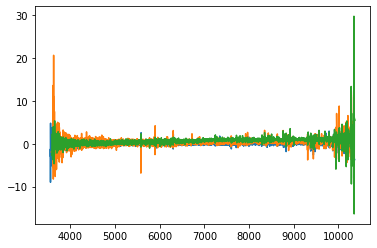

In [12]:

ii = 0
min_wl= 10000
max_wl= 0
num_npixs = []
img_coeffs1 = []
img_coeffs2 = []

for image in tfds.as_numpy(ds):
    log10wl = image['coeffs'][0] + image['coeffs'][1] * np.arange(image['coeffs'][2][0])
    if de_redshift:
        log10wl = log10wl-np.log10(1+image['redshift'])
    if max(log10wl)>max_wl:
        max_wl= max(log10wl)
    if min(log10wl)<min_wl:
        min_wl=min(log10wl)
    if image['coeffs'][2] not in num_npixs:
        num_npixs.append(image['coeffs'][2][0])
        img_coeffs1.append(image['coeffs'][1][0])
    if image['coeffs'][0] not in img_coeffs2:
        img_coeffs2.append(image['coeffs'][0][0])
    if ii<3:
        print(image['redshift'], image['label'])
        plt.plot(10**log10wl,image['flux'])
        ii+=1
wl_range = (min_wl, max_wl) 

In [13]:
print(wl_range)

(3.549499988555908, 4.017000073290546)


In [14]:
print(len(num_npixs))

43


In [15]:
num_npixs = np.sort(np.asarray(num_npixs))

In [16]:
np.unique(img_coeffs1), np.unique(img_coeffs2)

(array([1.e-04], dtype=float32),
 array([3.5495, 3.5502, 3.5504, 3.5505, 3.5506, 3.5507, 3.5508, 3.5509,
        3.5511, 3.5513, 3.5514, 3.5515, 3.5516, 3.5517, 3.5518, 3.5519,
        3.552 , 3.5521, 3.5523, 3.5525, 3.5526, 3.5527, 3.5529, 3.5531,
        3.5532, 3.5534, 3.554 , 3.5542, 3.5543, 3.5544, 3.5545, 3.5546,
        3.5548, 3.5549, 3.555 , 3.5551, 3.5565], dtype=float32))

In [17]:
num_npixs

array([4595., 4607., 4608., 4609., 4610., 4611., 4615., 4616., 4618.,
       4619., 4622., 4625., 4629., 4632., 4634., 4635., 4638., 4639.,
       4641., 4643., 4644., 4645., 4646., 4647., 4648., 4649., 4650.,
       4651., 4652., 4653., 4654., 4655., 4656., 4657., 4660., 4661.,
       4662., 4663., 4664., 4665., 4666., 4668., 4670.], dtype=float32)

In [18]:
# compute number of pixels that span entire wl range:
npix_max = int((wl_range[1]-wl_range[0])/np.unique(img_coeffs1))
print(npix_max)

4675


In [19]:
# computing padding to align all spectra in wavelength
# log10 wl_min = c0-c1*pad_left  - log10(1+z)
# log10 wl_max = c0+c1*npix+c1*pad_right - log10(1+z)

In [117]:
# mask (inverse noise weight or add noise) -> padding (takes care of de-redshifting)

def preprocessing(d, de_redshift):
    data               = d['flux']
    if de_redshift:
        pad_left       = (wl_range[0]+ tf.math.log(1+d['redshift'])/tf.math.log(10.)-d['coeffs'][0][0])/(-d['coeffs'][1][0])
        pad_right      = (wl_range[1]+ tf.math.log(1+d['redshift'])/tf.math.log(10.)-d['coeffs'][0][0])/(d['coeffs'][1][0])
    else:
        pad_left       = (wl_range[0]-d['coeffs'][0][0])/(-d['coeffs'][1][0])
        pad_right      = (wl_range[1]-(d['coeffs'][1][0]*d['coeffs'][2][0]+d['coeffs'][0][0]))/(d['coeffs'][1][0])
    pad_left       = tf.maximum(tf.math.round(pad_left),0)    
    pad_right      = tf.maximum(tf.math.round(pad_right),0)
    if not tf.math.equal(pad_left+pad_right+d['coeffs'][2][0]-npix_max,0):
        if tf.math.greater(pad_left, pad_right):
            pad_left=pad_left-1
        else:
            pad_right=pad_right-1
    pad_left       = tf.cast(pad_left,tf.int32)
    pad_right      = tf.cast(pad_right,tf.int32)
    padded         = tf.pad(data, [[pad_left,pad_right],[0,0]])
    padded_mask    = tf.pad(tf.cast(d['and_mask'],tf.float32), [[pad_left,pad_right],[0,0]])
    padded_noise   = tf.pad(d['inv_var'], [[pad_left,pad_right],[0,0]])

    return dict(flux=padded, mask=padded_mask,  inverse=padded_noise, z=d['redshift'])
    

In [118]:
prep_data = ds.map(lambda x, de_redshift=de_redshift: preprocessing(x, de_redshift))

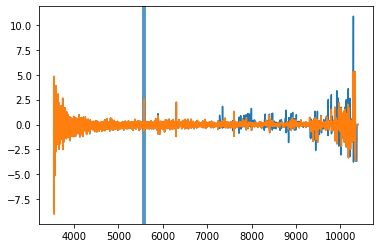

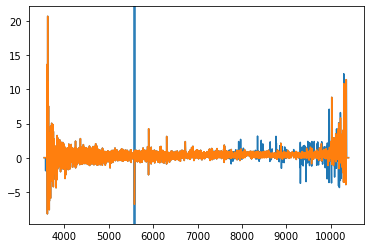

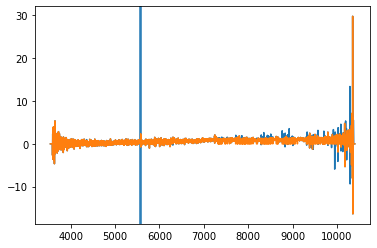

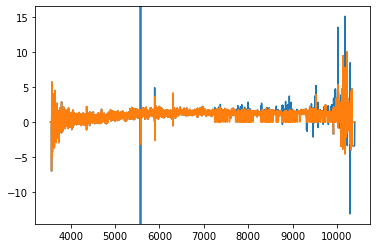

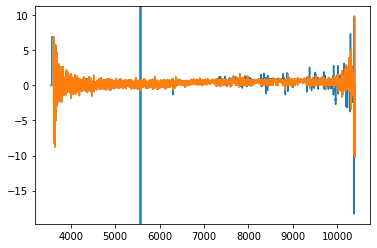

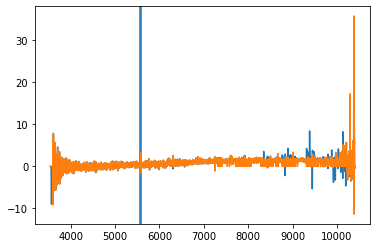

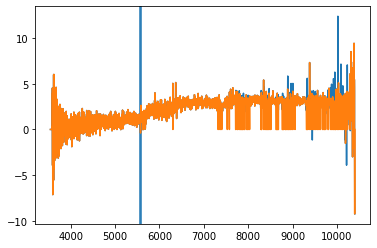

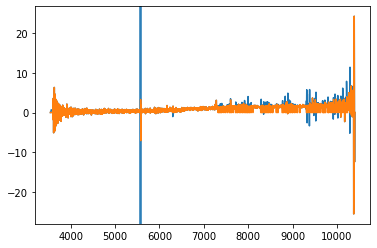

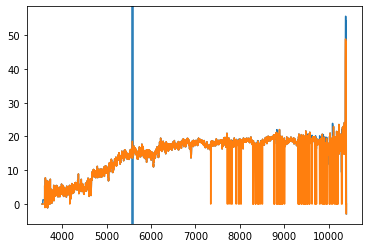

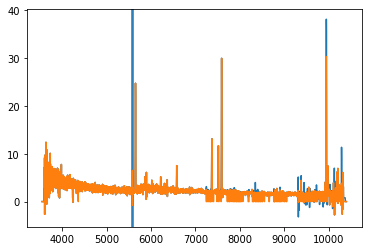

In [204]:
shapes = []
wls = 10**np.linspace(min_wl,max_wl,npix_max)
for ii, image in enumerate(tfds.as_numpy(prep_data)):
    if ii in np.arange(10):
        plt.axvline(5560)
        plt.axvline(5590)
        plt.plot(wls,image['flux'])
        plt.plot(wls,image['flux']*image['mask'])
    if image['flux'].shape not in shapes:
        shapes.append(image['flux'].shape)
    plt.show()

In [122]:
shapes

[(4675, 1)]

### write a simple LSTM model

In [123]:
latent_dim = 32
dim        = npix_max

In [124]:
network_type='fully_connected'

In [ ]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask


input = Input(shape=(dim, 1))
input1 = Input(shape=(dim, 1))
input2 = Input(shape=(dim, 1))
input_float = Input(shape=(1))

if network_type=='fully_connected':
# simplest, not many architectural choices other than number of neurons, likely to overfit
    x = Reshape((dim,))(input)
    x = LeakyReLU()(Dense(128)(x))
    x = Dense(latent_dim)(x)
    x = LeakyReLU()(Dense(128)(x))
    x = Dense(dim, name='bottleneck')(x)
    x = Reshape((dim,1))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(64, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(64, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=32,kernel_size=(4), strides=2, padding='valid')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(filters=32,kernel_size=(4), strides=2, padding='valid')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(4)(x)
    x = Flatten()(x)
    x = Dense(latent_dim, name='bottleneck')(x)
    x = Dense(145*32)(x)
    x = Reshape((145,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(4),strides=2, padding='valid')
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(4)(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(4),strides=2, padding='valid')
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2)(x)
    x, _ = Lambda( lambda x: tf.split(x,num_or_size_splits=(dim,1),axis=1))(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics):
        super().compile(optimizer,metrics)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data= data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            print(input_data[0][0])
            y_pred = self(input_data[0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}



# def custom_metric(y_true, y_pred):
#     loss = tf.math.square(y_true[0]-y_pred)#*y_true[2]
#     valid_loss = tf.reduce_mean(loss)#tf.boolean_mask(loss,y_true[1]))
#     return valid_loss
    
    
    
lstm_ae = CustomModel(inputs=[input, input1,input2], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(), my_loss=lossFunction, metrics=['mse'])

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

In [174]:
from tensorflow.keras.layers.experimental import preprocessing

layer_normalize = preprocessing.Normalization()
layer_normalize.adapt(prep_data.map(lambda x: x['flux']))

In [175]:
for i, l in enumerate(lstm_ae.layers):
    print(f'layer {i}: {l}')
    print(f'has input mask: {l.input_mask}')
    print(f'has output mask: {l.output_mask}')

layer 0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aabdce64340>
has input mask: None
has output mask: None
layer 1: <tensorflow.python.keras.layers.core.Reshape object at 0x2aac228d01f0>
has input mask: None
has output mask: None
layer 2: <tensorflow.python.keras.layers.core.Dense object at 0x2aac228d03a0>
has input mask: None
has output mask: None
layer 3: <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac228d0fa0>
has input mask: None
has output mask: None
layer 4: <tensorflow.python.keras.layers.core.Dense object at 0x2aad04b204c0>
has input mask: None
has output mask: None
layer 5: <tensorflow.python.keras.layers.core.Dense object at 0x2aac21e4c4c0>
has input mask: None
has output mask: None
layer 6: <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac21e4cd90>
has input mask: None
has output mask: None
layer 7: <tensorflow.python.keras.layers.core.Dense object at 0x2aabdda97f40>
has input mask: None


In [176]:
BATCH_SIZE   = 64

train_size   = int(0.6 * DATASET_SIZE)
test_size    = int(0.2 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)

train_dataset = prep_data.take(train_size).repeat().map(lambda x: ((layer_normalize(x['flux']), x['mask'], x['inverse']),layer_normalize(x['flux']))).batch(BATCH_SIZE)
test_dataset  = prep_data.skip(train_size).take(test_size).map(lambda x: ((layer_normalize(x['flux']), x['mask'], x['inverse']),layer_normalize(x['flux']))).batch(BATCH_SIZE)
valid_dataset = prep_data.skip(train_size+test_size).take(valid_size).map(lambda x:((layer_normalize(x['flux']), x['mask'], x['inverse']),layer_normalize(x['flux']))).batch(BATCH_SIZE)


In [177]:
history = lstm_ae.fit(train_dataset,validation_data=valid_dataset, epochs=2, steps_per_epoch=train_size//BATCH_SIZE)

Epoch 1/2
546/546 [==============================] - 48s 89ms/step - training_loss: 0.1173 - val_loss: 3.0405
Epoch 2/2
546/546 [==============================] - 45s 83ms/step - training_loss: 0.1174 - val_loss: 3.0196


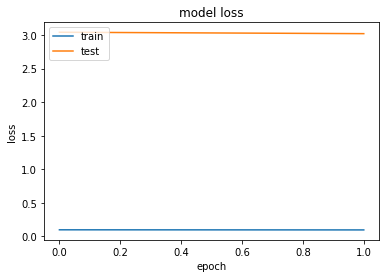

In [178]:
plt.plot(history.history['training_loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [179]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
  # create an empty model
  new_model = Sequential()
  for ix in range(starting_layer_ix, ending_layer_ix + 1):
    curr_layer = main_model.get_layer(index=ix)
    # copy this layer over to the new model
    new_model.add(curr_layer)
  return new_model

In [180]:
encoder = Model(inputs=lstm_ae.inputs, outputs=lstm_ae.layers[4].output)
encoded = encoder.predict(valid_dataset.take(1))
# decoder = extract_layers(model, 1, -1)
recon_train   = lstm_ae.predict(train_dataset.take(1))
recon_test    = lstm_ae.predict(test_dataset.take(1))

In [181]:
recon_test[0].shape, encoded.shape

((4675, 1), (64, 32))

(4675, 1)


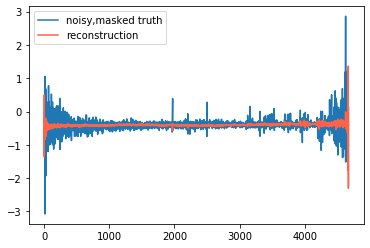

(4675, 1)


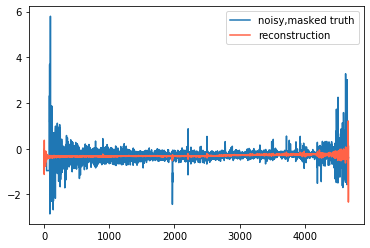

(4675, 1)


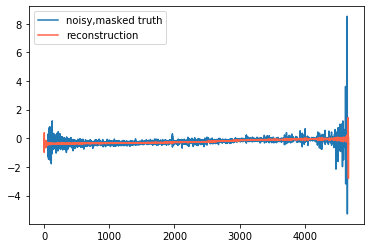

(4675, 1)


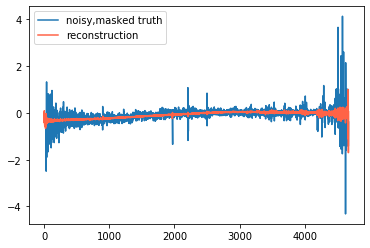

(4675, 1)


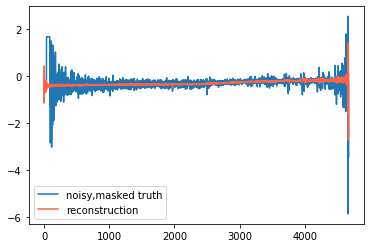

(4675, 1)


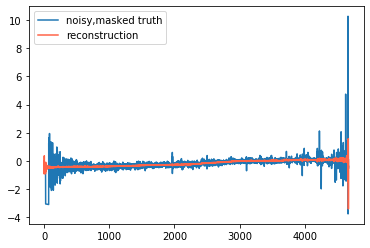

(4675, 1)


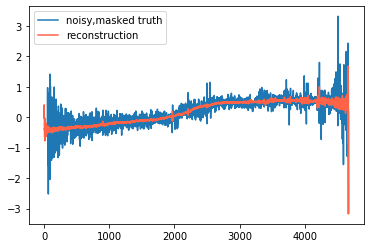

(4675, 1)


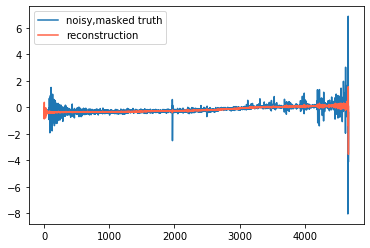

(4675, 1)


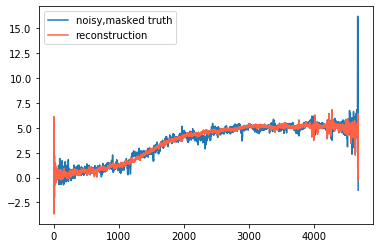

(4675, 1)


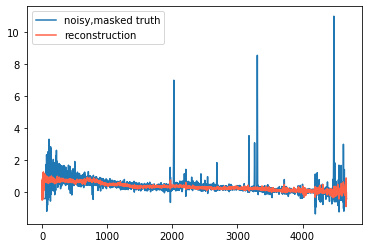

(4675, 1)


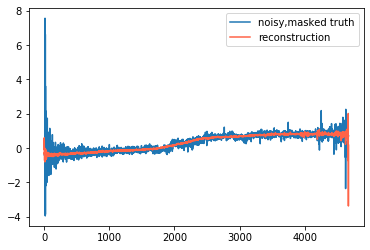

(4675, 1)


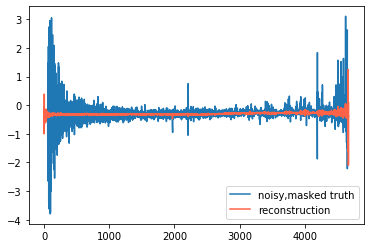

(4675, 1)


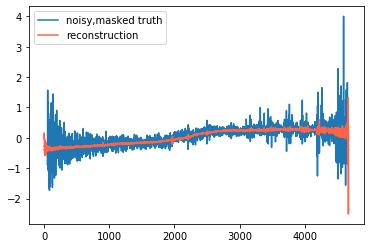

(4675, 1)


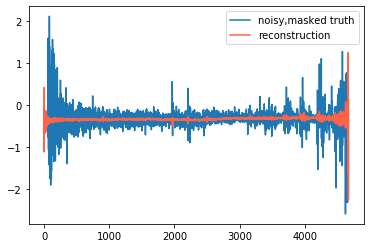

(4675, 1)


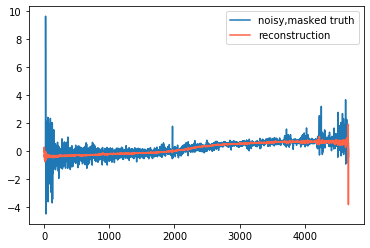

(4675, 1)


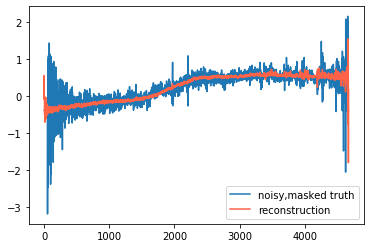

(4675, 1)


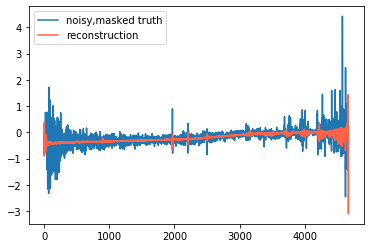

(4675, 1)


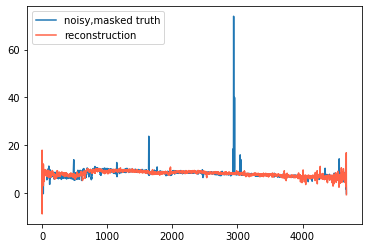

(4675, 1)


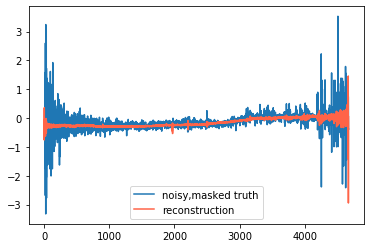

(4675, 1)


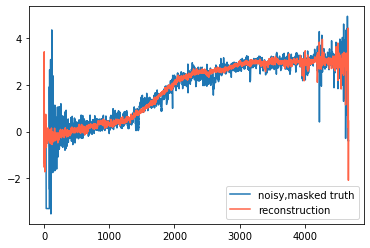

In [206]:
for train in train_dataset.take(1):
    for ii in range(20):
        plt.plot(train[0][0][ii],label='noisy,masked truth')
        errs = np.ones(npix_max)
        print(train[0][2][ii].shape)
        errs[np.where(train[0][2][ii]!=0)[0]]=0#np.sqrt(1./train[0][2][ii][np.where(train[0][2][ii]!=0)])[:,0]
        plt.errorbar(np.arange(npix_max),recon_train[ii],label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        plt.legend()
        plt.show()

In [ ]:
for test in test_dataset.take(1):
    for ii in range(20):
        plt.plot(test[0][0][ii],label='noisy,masked truth')
        errs = np.ones(npix_max)
        errs[np.where(recon_test[2][ii]!=0)[0]]=np.sqrt(1./recon_test[2][ii][np.where(recon[2][ii]!=0)])
        plt.errorbar(np.arange(npix_max),recon_test[0][ii],yerr=errs,label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        plt.legend()
        plt.show()